In [1]:
#|export
import torch
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *
from miniai.datasets import DataLoaders

from miniai.my_learner import Learner

from fastprogress import progress_bar,master_bar

In [2]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close
     

/Users/carles/mambaforge/envs/miniai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
logging.disable(logging.WARNING)

# Learner

In [5]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [6]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [7]:
bs = 1024
tds = dsd.with_transform(transformi)

In [9]:
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [10]:
n, nh = 28*28, 50
model = torch.nn.Sequential(torch.nn.Linear(n, nh), torch.nn.ReLU(), torch.nn.Linear(nh, 10))

In [11]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

# Metric

In [17]:
class Metric:
    def __init__(self):
        self.reset()
    def reset(self):
        self.vals, self.ns = [], []
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    
    @property
    def value(self):
        ns = torch.tensor(self.ns)
        return (torch.tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs):
        return inps

In [18]:
class Accuracy(Metric):
    def calc(self, inps, targs):
        return (inps == targs).float().mean()

In [19]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [20]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

# Some callbacks

In [46]:
class DeviceCB(Callback):
    def __init__(self, device=def_device):
        fc.store_attr()
    def before_fit(self):
        self.learn.model.to(self.device)
    def before_batch(self):
        self.learn.batch = to_device(self.learn.batch, device=self.device)

In [47]:
from torcheval.metrics import MulticlassAccuracy, Mean

In [48]:
def to_cpu(x):
    if isinstance(x, Mapping):
        return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x,list):
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple):
        return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [49]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms:
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
        
    def _log(self, d):
        print(self.learn.epoch, self.learn.model.training, d)
        
    def before_fit(self):
        self.learn.metrics = self
        
    def before_epoch(self):
        [o.reset() for o in self.all_metrics.values()]
        
    def after_epoch(self):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = self.learn.epoch
        log['train'] = self.learn.model.training
        self._log(log)
        
    def aftert_batch(self):
        x,y = to_cpu(self.learn.batch)
        for m in self.metrics.values():
            m.update(to_cpu(self.learn.preds), y)
        self.loss.update(to_cpu(self.learn.loss), weight=len(x))

In [50]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

0 True {'accuracy': 'nan', 'loss': '0.000', 'epoch': 0, 'train': True}
0 False {'accuracy': 'nan', 'loss': '0.000', 'epoch': 0, 'train': False}


# Callbacks

In [51]:
def identity(*args):
    if not args:
        return
    x, *args = args
    return (x,) + tuple(args) if args else x

In [52]:
identity('a',1)

('a', 1)

In [53]:
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [54]:
def run_cbs(cbs, method_nm):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None:
            method()

In [55]:
class Callback():
    order = 0

In [56]:
class CompletionCB(Callback):
    def before_fit(self):
        self.count = 0
    def after_batch(self):
        self.count += 1
    def after_fit(self):
        print(f'Completed {self.count} batches')

In [57]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [58]:
class with_cbs:
    def __init__(self, nm):
        self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel {self.nm.title()}Exception']:
                pass
        return _f

In [59]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
        for cb in cbs:
            cb.learn = self
    
    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        
        try:
            self.callback('before_epoch')
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException:
                    pass
            self.callback('after_epoch')
        except CancelEpochException:
            pass    
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: 
            pass
    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm)

In [60]:
m, nh = 28*28, 50
def get_model():
    return torch.nn.Sequential(torch.nn.Linear(m,nh), torch.nn.ReLU(), torch.nn.Linear(nh, 10))

In [61]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 64 batches


In [62]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self):
        raise CancelEpochException()

In [63]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), CompletionCB()])
learn.fit(1)

Completed 64 batches


# Flexible Learner

In [64]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
        for cb in cbs:
            cb.learn = self
    
    @contextmanager
    def callback_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{name}')
        except globals()[f'Cancel{nm.title()}Exception']:
            pass
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        
        with self.callback_ctx('epoch'):
            for self.iter, self.batch in enumerate(self.dl):
                with self.callback_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
            
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        with self.callback_ctx('fit'):
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
    
    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'):
            return partial(self.callback, name)
        raise AttributeError(name)
    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm)

In [65]:
class TrainCB(Callback):
    def predict(self):
        self.learn.preds = self.learn.model(self.learn.batch[0])
    def get_loss(self):
        self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])
    def backward(self):
        self.learn.loss.backward()
    def step(self):
        self.learn.opt.step()
    def zero_grad(self):
        self.learn.opt.zero_grad()

In [66]:
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, plot=False):
        self.plot = plot
    def before_fit(self):
        self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
        if hasattr(self.learn, 'metrics'):
            self.learn.metrics._log = self._log
            self.losses = []
            
    def _log(self, d):
        self.mbar.write(str(d))
        
    def before_epoch(self):
        self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.mbar)
    def after_batch(self):
        self.learn.dl.comment = f'{self.learn.loss:.3f}'
        if self.plot and hasattr(self.learn, 'metrics') and self.learn.model.training:
            self.losses.append(self.learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [67]:
model = get_model()

In [68]:
metrcis = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

# TrainingLearner subclass

In [73]:
class MomentumLearner(Learner):
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)
    def predict(self):
        self.preds = self.model(self.batch[0])
    def get_loss(self):
        self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self):
        self.loss.backward()
    def step(self):
        self.opt.step()
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters():
                p.grad *= 0.85

In [74]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

# LRFinder

In [80]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3):
        fc.store_attr()
        
    def before_fit(self):
        self.lrs, self.losses = [], []
        self.min = math.inf
    
    def after_batch(self):
        if not self.learn.model.training:
            raise CancelEpochException()
        self.lrs.append(self.learn.opt.param_groups[0]['lr'])
        loss = to_cpu(self.learn.loss)
        self.losses.append(loss)
        if loss < self.min:
            self.min = loss
        if loss > self.min*3:
            raise CancelFitException()
        for g in self.learn.opt.param_groups:
            g['lr'] *= self.lr_mult
    
    def plot(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [81]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), ProgressCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)

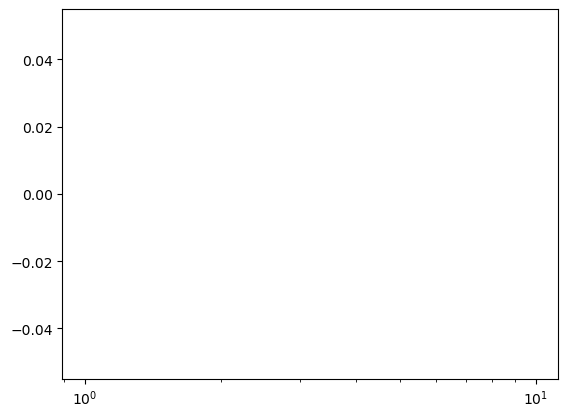

In [82]:
lrfind.plot()

In [83]:
from torch.optim.lr_scheduler import ExponentialLR

In [86]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3):
        fc.store_attr()
        
    def before_fit(self):
        self.sched = ExponentialLR(self.learn.opt, self.gamma)
        self.lrs, self.losses = [], []
        self.min = math.inf
    
    def after_batch(self):
        if not self.learn.model.training:
            raise CancelEpochException()
        self.lrs.append(self.learn.opt.param_groups[0]['lr'])
        loss = to_cpu(self.learn.loss)
        self.losses.append(loss)
        if loss < self.min:
            self.min = loss
        if loss > self.min*3:
            raise CancelFitException()
        for g in self.learn.opt.param_groups:
            g['lr'] *= self.lr_mult
            
        self.sched.step()
    
    def after_fit(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')    